In [1]:
import sys 
sys.path.append(rf"/nfs/home/genovese/thesis-wildfire-genovese/src")
from importlib import reload
import utils
reload(utils)
from utils import *

See /nfs/home/genovese/thesis-wildfire-genovese/outputs/EDA_ProfileReport.html for the EDA, here the consequent preprocessing

In [ ]:
data = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/dataset_with_days_enumerated.csv')

### 1. drop duplicates and constant variables

In [ ]:
data.drop_duplicates(inplace=True)
data.drop(columns=['VEGETAZIONE_TIPO_Saliceto paludoso di Salix cinerea',
                   'VEGETAZIONE_TIPO_Larici-cembreto su rodoreto-vaccinieto',
                   'VEGETAZIONE_INTERVENTO_Gestione a governo misto'],
                   inplace=True)

### 2. Check for almost constant variables

In [ ]:
for c in data.columns:
    vals = data[c].value_counts().sort_values(ascending = False)
    if vals.iloc[1:].sum() <= 50:
        print(f'Column {c} has value counts: ', vals)

In [ ]:
# data['TOTALE_VEGETAZIONE'] = data.loc[:, [col for col in data.columns if 'VEGETAZIONE_TIPO' in col]].sum(axis=1)
# data['TOTALE_STRADE'] = data.loc[:, [col for col in data.columns if 'RTP' in col]].sum(axis=1)

In [ ]:
to_drop = []

for c in data.columns:
    vals = data[c].value_counts().sort_values(ascending = False)
    if vals.iloc[1:].sum() <= 10:
        if np.max(list(vals.index)) < 0.1:
            to_drop.append(c)

In [ ]:
# data.drop(columns=to_drop, inplace=True)

### 3. Look for too high correlations and drop under necessity

In [ ]:
def find_high_corr_pairs(df, threshold=0.9):
    corr = df.corr()  # compute correlation matrix
    # Extract only upper triangle (exclude duplicates and self-correlation)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    # Stack into long format and filter
    high_corr = upper.stack().loc[lambda x: x.abs() > threshold]
    # Result is a Series with MultiIndex (col1, col2) and value = correlation

    return high_corr

In [ ]:
high_corr = find_high_corr_pairs(data, threshold=0.95)
for s in high_corr.index:
    print(s)

In [ ]:
save_clean_data(data, 'processed_not_imputed_non_rekriged', '/nfs/home/genovese/thesis-wildfire-genovese/database/cache')

### 4. Reintroduce target

In [ ]:
data = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/cache/processed_not_imputed_non_rekriged.csv')
kriged = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/src/OnFireForest/sentinel_negative_fires/ambiguous.geojson')
negatives = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/src/OnFireForest/sentinel_negative_fires/negatives.geojson')

In [3]:
data['target'] = [None]*data.shape[0]

for idx, target in zip(kriged.id, kriged.label):
    j = data[data.fire_id == idx].index
    data.loc[j, 'target'] = target

for idx in negatives.id:
    j = data[data.fire_id == idx].index
    data.loc[j, 'target'] = 0

data.loc[:, 'target'] = data.target.fillna(1)

/tmp/ipykernel_368259/626330105.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[:, 'target'] = data.target.fillna(1)


In [5]:
import pickle 
with open('/nfs/home/genovese/thesis-wildfire-genovese/src/trained_models/target_kriging.pkl', 'rb') as f:
    krige = pickle.load(f)

In [6]:
krige.get_params()

{'anisotropy_angle': (0.0, 0.0, 0.0),
 'anisotropy_scaling': (1.0, 1.0),
 'coordinates_type': 'euclidean',
 'drift_terms': None,
 'enable_statistics': False,
 'exact_values': True,
 'ext_drift_grid': (None, None, None),
 'functional_drift': None,
 'method': 'ordinary',
 'n_closest_points': 10,
 'nlags': 8,
 'point_drift': None,
 'pseudo_inv': False,
 'pseudo_inv_type': 'pinv',
 'variogram_function': None,
 'variogram_model': 'spherical',
 'variogram_parameters': {'psill': 1.5, 'range': 1.5, 'nugget': -1},
 'verbose': False,
 'weight': False}

In [ ]:
from shapely import wkt

data2 = data.copy(deep=True)
for idx, target in zip(negatives.id, krige.predict(np.array(pd.concat([negatives.geometry.centroid.x, negatives.geometry.centroid.y], axis=1)))):
    j = data2[data2.fire_id == idx].index
    data2.loc[j, 'target'] = target

positives = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/table_data_input.csv').drop(index=0)
positives['ignition_point (epsg=3857)'] = positives['ignition_point (epsg=3857)'].apply(wkt.loads)
positives = gpd.GeoDataFrame(positives, geometry='ignition_point (epsg=3857)', crs = 'EPSG:3857')
for idx, target in zip(positives.fire_id, krige.predict(np.array(pd.concat([positives.geometry.x, positives.geometry.y], axis=1)))):
    j = data2[data2.fire_id == idx].index
    data2.loc[j, 'target'] = target

In [ ]:
save_clean_data(data, 'processed_not_imputed_non_rekriged', '/nfs/home/genovese/thesis-wildfire-genovese/database/cache')
save_clean_data(data2, 'processed_not_imputed_rekriged', '/nfs/home/genovese/thesis-wildfire-genovese/database/cache')

### 5. Assign target interval

In [ ]:
data1 = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/cache/processed_not_imputed_rekriged.csv')
data2 = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/cache/processed_not_imputed_non_rekriged.csv')

In [ ]:
def classify_target(row, target='target'):
    if row[target] <= 0.2:
        return 0
    elif (row[target] > 0.2) and (row[target] <= 0.4):
        return 1
    elif (row[target] > 0.4) and (row[target] <= 0.6):
        return 2
    elif (row[target] > 0.6) and (row[target] <= 0.8):
        return 3
    elif row[target] > 0.8:
        return 4
    
data1['label'] = data1.apply(lambda x: classify_target(x), axis=1)
data2['label'] = data2.apply(lambda x: classify_target(x), axis=1)

In [ ]:
(data1.label == data2.label).all()

No difference between kriged and not for the label

In [ ]:
data1.to_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/not_imputed_dataset_non_kriged.csv')
data2.to_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/not_imputed_dataset_kriged.csv')

### 6. NA imputing
see knn_imputer.py, to do inside each kfold

In [2]:
data1 = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/not_imputed_dataset_non_kriged.csv')
data2 = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/database/model_input/not_imputed_dataset_kriged.csv')

<Figure size 600x600 with 0 Axes>

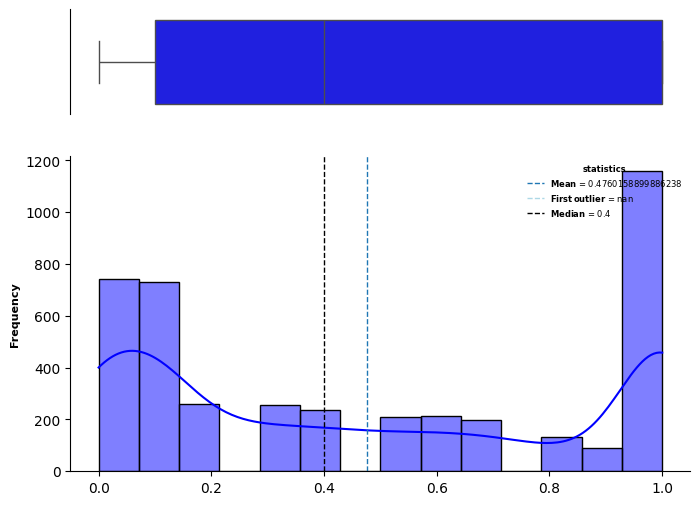

In [4]:
histbox(data1.target)